# Scholarly Recommender 

This notebook is showcasing a scholarly recommender model.  The model takes in a string as a keyword, and then uses that string to provide 5 recommended articles and analytics on the scholarly data side of it using visuals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot
import plotly.express as px


# Data Scraping and Extraction

I will use the entrez python library to pull a collection of documents relating to our pre-set keyword from the NCBI servers and slot them in a dataframe.

In [2]:
'''
Data extraction code referenced from here: https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547

input:
- a string keyword to search the documents for
- a boolean to determine if a csv copy of the document should be saved locally so that I don't have to repull everytime

export:
- returns a df containing the scholarly data
- if save is set to True, a csv file of the pulled data will also be saved in the data folder
'''
def entrez_pull_df(keyword, save = False):
    Entrez.email = "awyeh450471@gmail.com"

    keyword = keyword

    result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
    print(
        "Total number of publications that contain the term {}: {}".format(
            keyword, result["Count"]
        )
    )

    MAX_COUNT = result["Count"]
    result = Entrez.read(
        Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
    )

    ids = result["IdList"]

    batch_size = 100
    batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

    record_list = []
    for batch in tqdm(batches):
        h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
        records = Medline.parse(h)
        record_list.extend(list(records))
    print("Complete.")
    
    df = pd.DataFrame(record_list)
    if save == True:
        df.to_csv(f'../../data/{keyword}.csv', index = False)
    return df

In [ ]:
df_base = entrez_pull_df('hay fever', False)

I also have the option of skipping the download process and have the ability of pulling local copies of pre-downloaded databases.

In [3]:
'''
a function to pull data from an existing local csv file

input:
- a string keyword to search the documents for

output:
- returns a df containing the scholarly data

todo:
- add code that checks if the csv exists
'''
def local_pull_df(keyword):
    df = pd.read_csv(f'../../data/{keyword}.csv', low_memory = False)
    return df

In [4]:
df_base = local_pull_df('hay fever')

In [8]:
df_base[df_base['RF'].isna()].shape

(14439, 77)

# Data Preprocessing and Cleaning

Column Names and Respective Field Values

| Column | Field | Column | Field |
|--------|-------|--------|-------|
|'AB'|Abstract|'JID'|NLM Unique ID|
|'AD'|Affiliation|'JT'|Journal Title|
|'AID'|Article Identifier|'LA'|Language|
|'AU'|Author|'LID'|Location Identifier|
|'AUID'|Author Identifier|'LR'|Date Last Revised|
|'BTI'|Book Title|'MHDA'|MeSH Date|
|'CDAT'| |'MID'|Manuscript Identifier|
|'CI'|Copyright Information|'MH'|MeSH Terms|
|'CIN'|Comment In|'OID'|Other ID|
|'CN'|Corporate Author|'OT'|Other Term|
|'COIS'|Conflict of Interest Statement
|'CON'|Comment On|'OWN'|Owner|
|'CP'| |'PB'| |
|'CRDT'|Create Date|'PG'|Pagination|
|'CTDT'| |'PHST'|Publication History Status|
|'DA'|Date Created|'PL'|Place of Publication|
|'DCOM'|Date Completed|'PMC'|Pubmed Central Identifier|
|'DEP'|Date of Electronic Publication|'PMCR'|PubMed Central Release|
|'DP'|Date of Publication|'PMID'|PubMed Unique Identifier|
|'DRDT'| |'PS'|Personal Name as Subject|
|'ECI'|Expression of Concern|'PST'|Publication Status|
|'ED'|Editor Name|'PT'|Publication Type|
|'EFR'|Erratum For|'RF'|Number of References|
|'EIN'|Erratum in|'RIN'|Retraction In|
|'EDAT'|Entrez Date|'RN'|Registry Number|
|'FAU'|Full Author|'RPF'|Republished From|
|'FED'|Full Editor Name|'RPI'|Republished In|
|'FIR'|Full Investigator Name|'SB'|Subset|
|'FPS'|Full Personal Name as Subject|'SI'|Secondary Source ID|
|'GN'|General Note|'SO'|Source|
|'GR'|Grant Number|'STAT'|Status|
|'GS'|Gene Symbol|'TA'|Journal Title Abbreviation|
|'IP'|Issue|'TI'|Title|
|'IR'|Investigator Name|'TT'|Transliterated Title|
|'IS'|ISSN|'VI'|Volume|
|'ISBN'|ISBN|


For the sake of minimizing clutter and improving visibility, I will only keep the columns that I might need and rename them to something that makes more sense.

In [16]:
cols = ['TI', 'AU', 'TA', 'EDAT', 'AB', 'MH', 'OT', 'RF', 'PL', 'LA']

df = df_base[cols]
df.columns = ['title', 'authors', 'journal', 'date', 'abstract', 'mesh_terms', 'other_terms', 'reference_number', 'location', 'language']

In [17]:
df.head()

,title,authors,journal,date,abstract,mesh_terms,other_terms,reference_number,location,language
0,Headache in girls and boys growing up from age...,"['Wijga AH', 'Gehring U', 'van de Putte EM', '...",Pain,2020/11/25 06:00,The striking difference between men and women ...,NaN,NaN,NaN,United States,['eng']
1,Trajectories of asthma and allergies from 7 ye...,"['Bui DS', 'Lodge CJ', 'Perret JL', 'Lowe A', ...",Lancet Respir Med,2020/11/21 06:00,BACKGROUND: Longitudinal trajectories of asthm...,NaN,NaN,NaN,England,['eng']
2,Risk factors and association with severity of ...,"['Sahebjada S', 'Chan E', 'Xie J', 'Snibson GR...",Int Ophthalmol,2020/11/18 06:00,SIGNIFICANCE: Our results show that asthmatic ...,NaN,"['Asthma', 'Eczema', 'Hay fever', 'Keratoconus...",NaN,Netherlands,['eng']
3,NaN,NaN,Arerugi,2020/11/17 06:00,NaN,NaN,"['FcepsilonRI', 'bronchial asthma', 'chronic i...",NaN,Japan,['jpn']
4,Gene Expression Analysis by Real-Time PCR in N...,"['Wang M', 'She W', 'Yang J', 'Wang X', 'Zhang...",Int Arch Allergy Immunol,2020/11/11 06:00,BACKGROUND: Epithelial gene expression in alle...,NaN,"['Allergic rhinitis', 'Epithelium', 'Nonallerg...",NaN,Switzerland,['eng']


An issue that is not visible right away is that many columns contains their data in lists that have been saved in the format of strings, such as authors and terms.  Thus I need a way of converting them back into lists in order to use them as such.  I will do some cleaning too while I'm at it as well.

In [116]:
'''
function for cleaning the dataframe values
annoyingly enough, most of the values are lists saved in the format of strings so it needs to be remade

input:
- a string

output:
- a cleaned version of it, it will be a list of terms where the whitespace between each phrase are underscores
'''
def clean(x):
    punctuation = '*&,\'-'
    s = x.strip('][').split(('\', '))
    s = [w for w in s if w != ', ']
    s = [w for w in s if w != '']
    s = [w.replace(' ', '_') for w in s]
    s = [w.replace('/', ' ') for w in s]
    s = [w.lower() for w in s]
    s = [w.translate(w.maketrans('', '', punctuation)) for w in s]
    return ' '.join(s)

'''
function for determining the year of the publication

input:
- string

output:
- the year in int format
'''
def year(x):
    return int(x[:4])

In [22]:
df_clean = df[~df['mesh_terms'].isna() | ~df['other_terms'].isna()].reset_index(drop = True)
df_clean.fillna({'title': '', 'authors': '', 'abstract': '', 'mesh_terms': '', 'other_terms': '', 'reference_number': 0}, inplace = True)

df_clean['authors'] = df_clean['authors'].apply(clean)
df_clean['journal'] = df_clean['journal'].apply(clean)
df_clean['location'] = df_clean['location'].apply(clean)
df_clean['year'] = df_clean['date'].apply(year)
df_clean['language'] = df_clean['language'].apply(clean)
df_clean['mh_t'] = df_clean['mesh_terms'].apply(clean)
df_clean['ot_t'] = df_clean['other_terms'].apply(clean)
df_clean['terms'] = df_clean['mh_t'] + df_clean['ot_t']


df_clean.drop(columns = ['date', 'mesh_terms', 'other_terms', 'mh_t', 'ot_t'], inplace = True)

Dataframe with cleaned up values, a bit harder to understand but will be usable in future code.

In [23]:
df_clean.head()

,title,authors,journal,abstract,reference_number,location,language,year,terms
0,Risk factors and association with severity of ...,sahebjada_s chan_e xie_j snibson_gr daniell_m ...,int_ophthalmol,SIGNIFICANCE: Our results show that asthmatic ...,0.0,netherlands,eng,2020,asthma eczema hay_fever keratoconus risk_factors
1,,,arerugi,,0.0,japan,jpn,2020,fcepsilonri bronchial_asthma chronic_idiopathi...
2,Gene Expression Analysis by Real-Time PCR in N...,wang_m she_w yang_j wang_x zhang_y zhang_x zha...,int_arch_allergy_immunol,BACKGROUND: Epithelial gene expression in alle...,0.0,switzerland,eng,2020,allergic_rhinitis epithelium nonallergic_rhini...
3,Grass pollen immunotherapy alters chromatin la...,sharif_h acharya_s dhondalay_gkr varricchi_g k...,j_allergy_clin_immunol,BACKGROUND: Allergen-specific immunotherapy (A...,0.0,united_states,eng,2020,atacseq allergy t_follicular_helper_cells t_fo...
4,Repetitive nasal allergen challenge in allergi...,orban_n jacobson_mr nouriaria_kt durham_sr eif...,clin_exp_allergy,BACKGROUND: Local tissue eosinophilia and Th2-...,0.0,england,eng,2020,allergic angiogenesis early_and_late_phase_res...


# Exploratory Data Analysis

A good eda to start with will be to view the top 10 terms in applicable columns.  Since the pandas method value_counts() does not work when the columns contain lists, I will instead concat the values in all rows together and use a Counter() instance to view how many there are.  We will be looking at the top 10 authors, journals, locations, languages, and terms, with 'top 10' determined by how many there are.  With this, we can see which of each metadata term that is more prominent in the dataframe.

In [117]:
'''
using the cleaned up columns, it will count the occurence of each term in all rows

input:
- a dataframe
- a column name

output:
- an instance of a Counter with the value counts of all terms
'''
def column_counter(df, col):
    s = ' '.join(df[col])
    # removes empty strings
    s = s.replace('  ', ' ')
    return Counter(s.split(' '))

In [63]:
print("Top 10 Authors")
top10_authors = column_counter(df_clean, 'authors').most_common(10)
print(top10_authors)
print("\nTop 10 Journals")
top10_journals = column_counter(df_clean, 'journal').most_common(10)
print(top10_journals)
print("\nTop 10 Locations")
top10_locations = column_counter(df_clean, 'location').most_common(10)
print(top10_locations)
print("\nTop 10 Languages")
top10_languages = column_counter(df_clean, 'language').most_common(10)
print(top10_languages)
print("\nTop 10 Terms")
top10_terms = column_counter(df_clean, 'terms').most_common(10)
print(top10_terms)

Top 10 Authors
[('ciprandi_g', 152), ('durham_sr', 136), ('bousquet_j', 128), ('canonica_gw', 107), ('naclerio_rm', 107), ('bachert_c', 103), ('meltzer_eo', 103), ('norman_ps', 87), ('lichtenstein_lm', 84), ('klimek_l', 81)]

Top 10 Journals
[('j_allergy_clin_immunol', 964), ('allergy', 810), ('ann_allergy_asthma_immunol', 510), ('clin_exp_allergy', 501), ('ann_allergy', 497), ('int_arch_allergy_immunol', 275), ('allergol_immunopathol_(madr)', 254), ('allergy_asthma_proc', 254), ('arerugi', 211), ('j_investig_allergol_clin_immunol', 207)]

Top 10 Locations
[('united_states', 5085), ('england', 2997), ('denmark', 1018), ('germany', 928), ('switzerland', 802), ('spain', 552), ('japan', 501), ('netherlands', 414), ('france', 393), ('poland', 387)]

Top 10 Languages
[('eng', 12040), ('ger', 843), ('fre', 475), ('jpn', 442), ('rus', 388), ('pol', 297), ('ita', 218), ('spa', 201), ('chi', 163), ('und', 103)]

Top 10 Terms
[('immunology', 22086), ('humans', 14629), ('rhinitis_allergic_seasona

In [118]:
'''
function for plotting the top 10 terms in the stated column

input:
- counter instance
- title for the plot

output:
- a plot
'''
def top10_plots(counter, title):
    sns.set(context = 'poster', style = 'white')

    x = [x[1] for x in counter]
    y = [y[0] for y in counter]
    yticks = [y[0].replace('_', ' ').title() for y in counter]
    title = title

    plt.figure(figsize=(20,10))
    ax = sns.barplot(x = x, y = y, orient = 'h', color = '#63d297')
    ax.set(yticklabels = yticks, title = title)
    sns.despine(top = True, right = True, bottom = False, left = False)

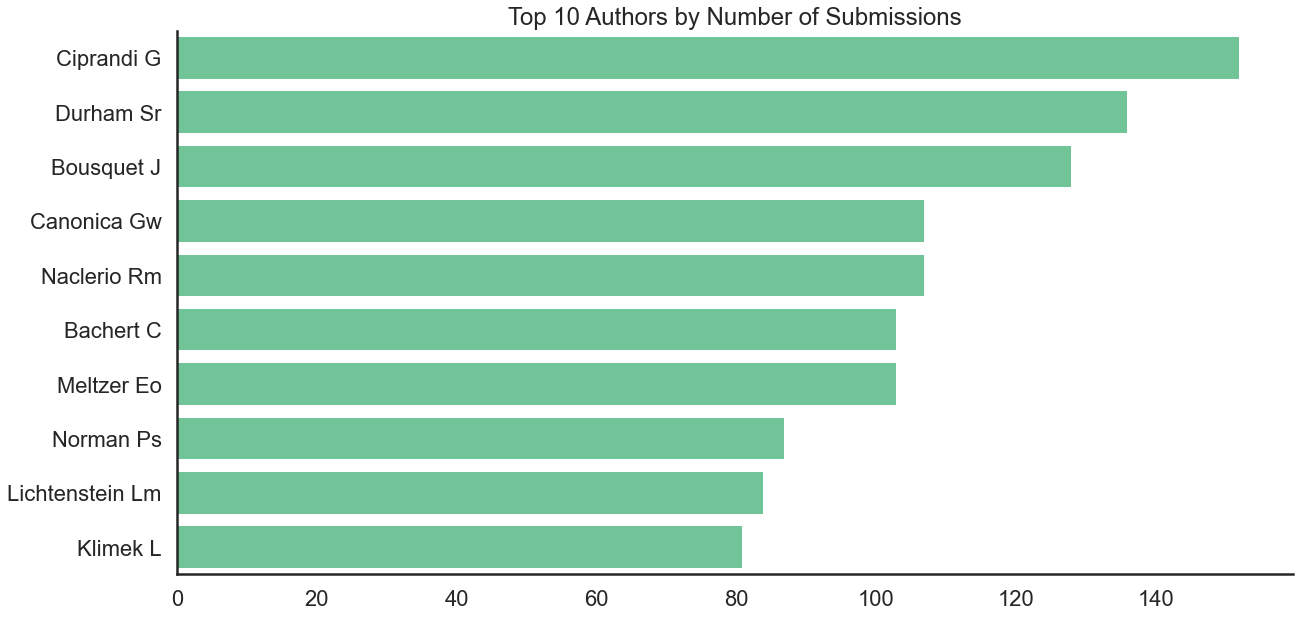

In [30]:
top10_plots(top10_authors, 'Top 10 Authors by Number of Submissions')

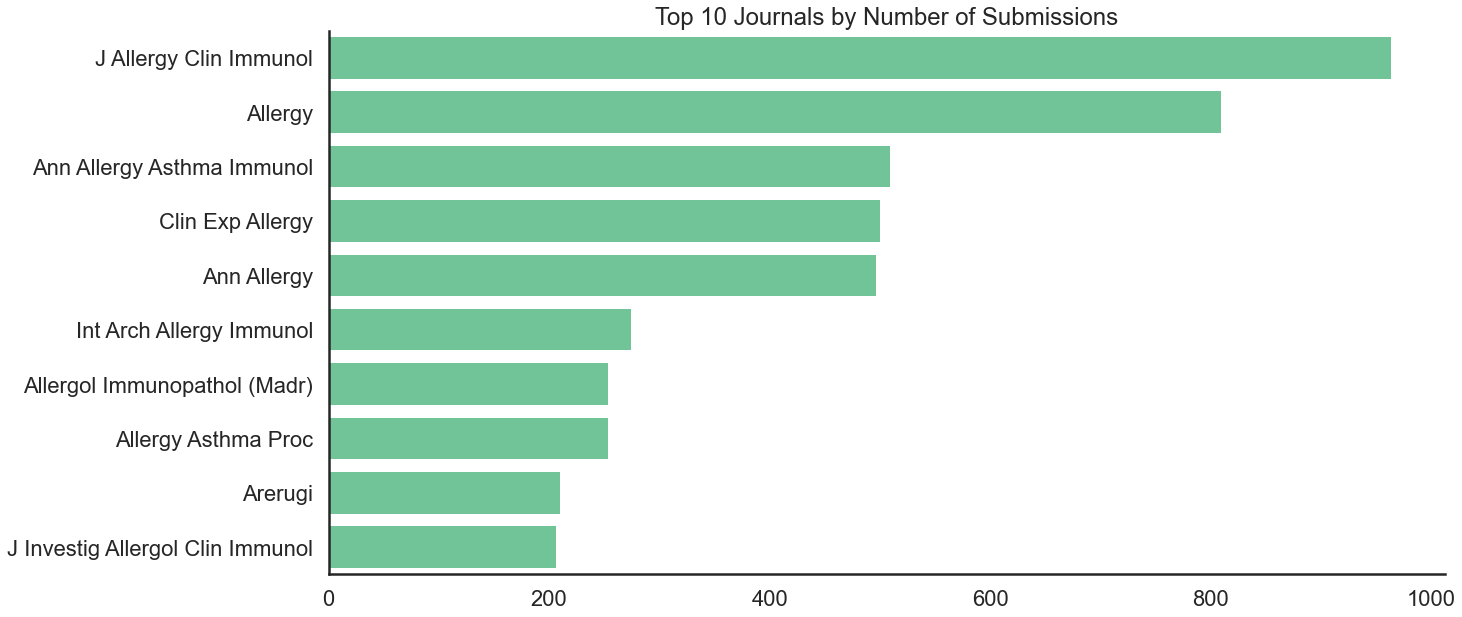

In [31]:
top10_plots(top10_journals, 'Top 10 Journals by Number of Submissions')

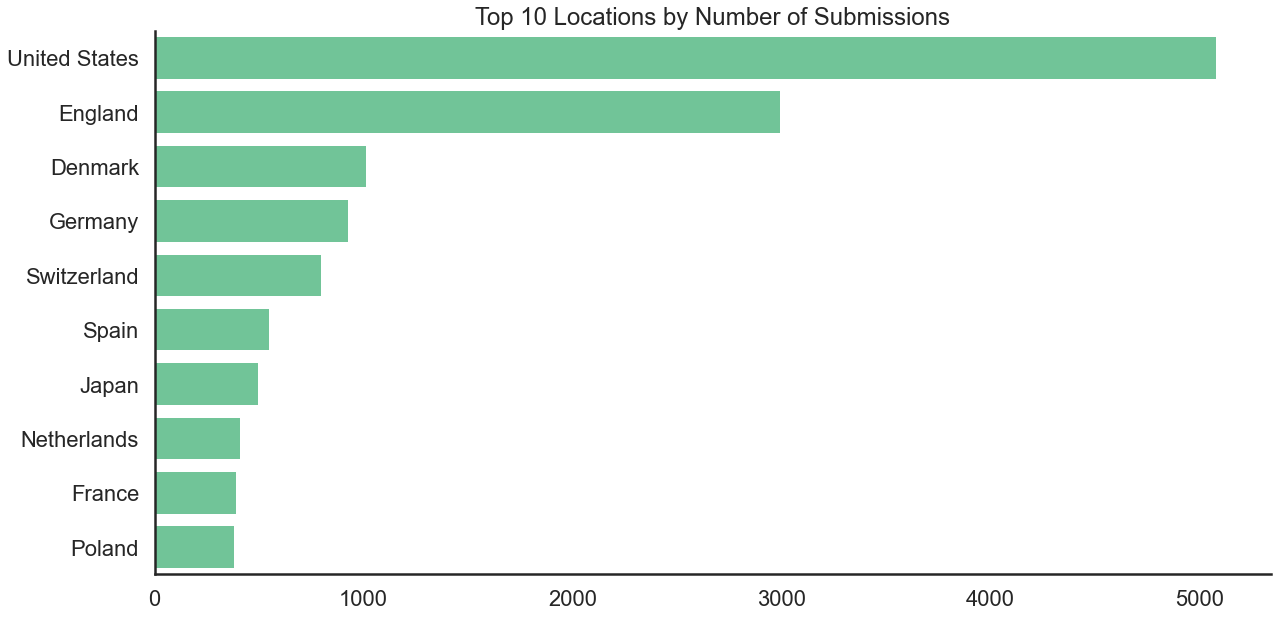

In [32]:
top10_plots(top10_locations, 'Top 10 Locations by Number of Submissions')

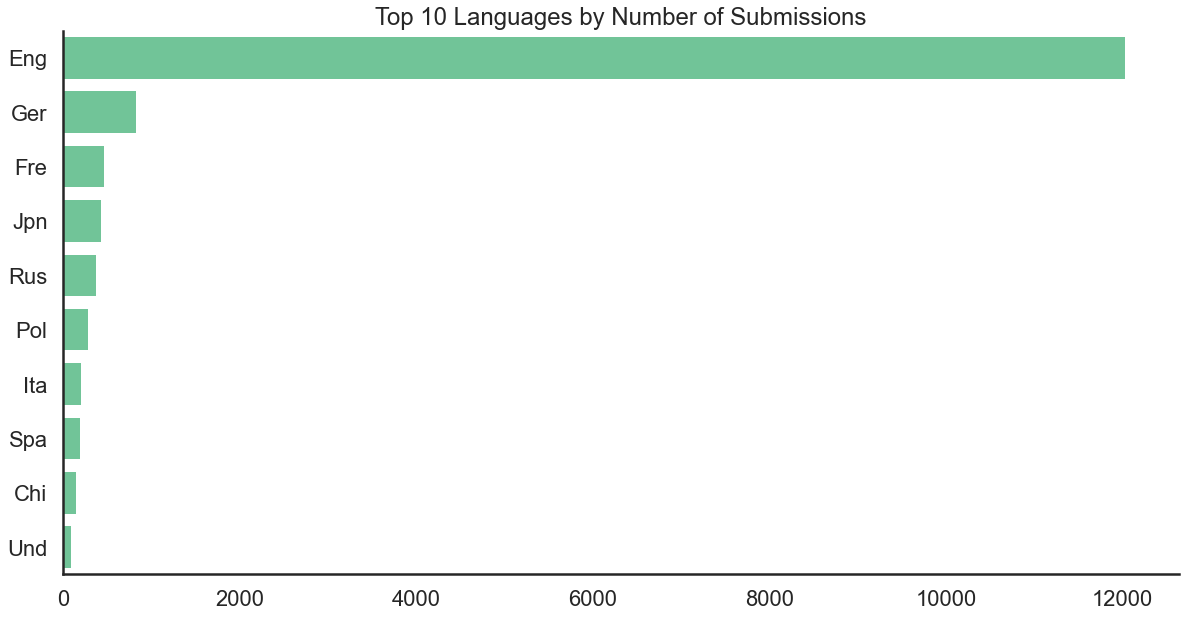

In [33]:
top10_plots(top10_languages, 'Top 10 Languages by Number of Submissions')

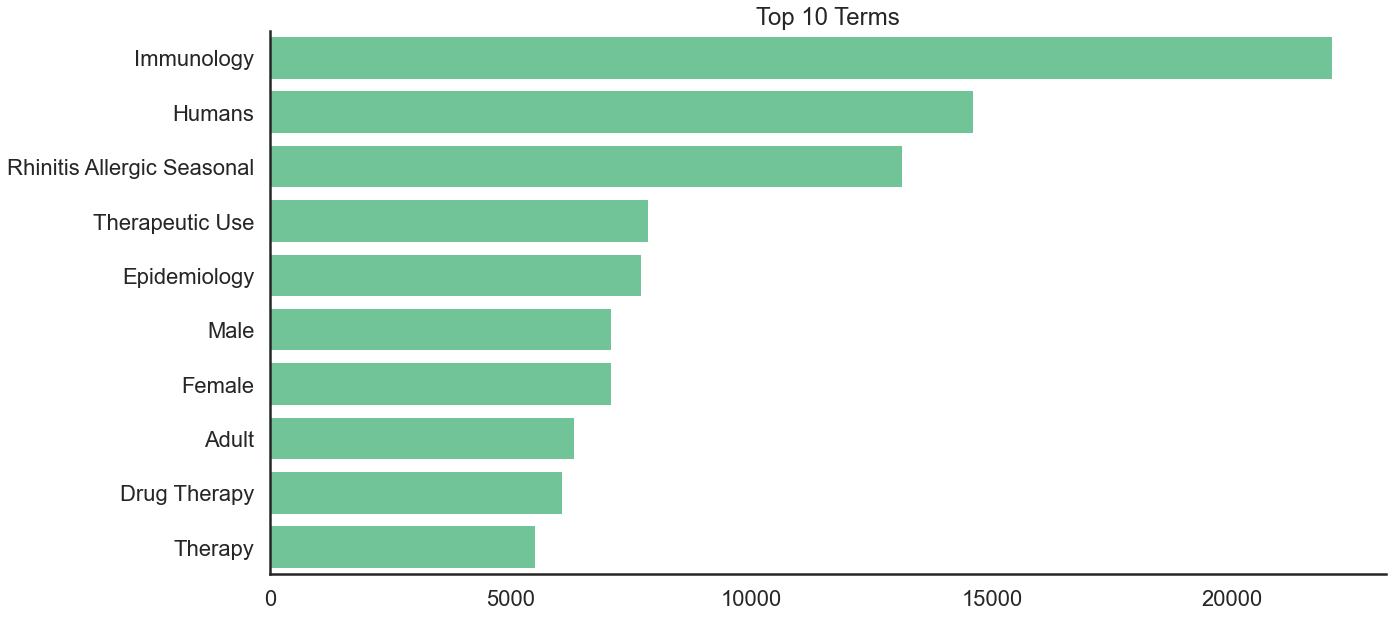

In [34]:
top10_plots(top10_terms, 'Top 10 Terms')

Another thing I can look at is the amount of publications through the last couple decades.  Here we can see that the number of publications rose steadily until 2010, but then quickly plummeted.

<Figure size 1440x720 with 0 Axes>

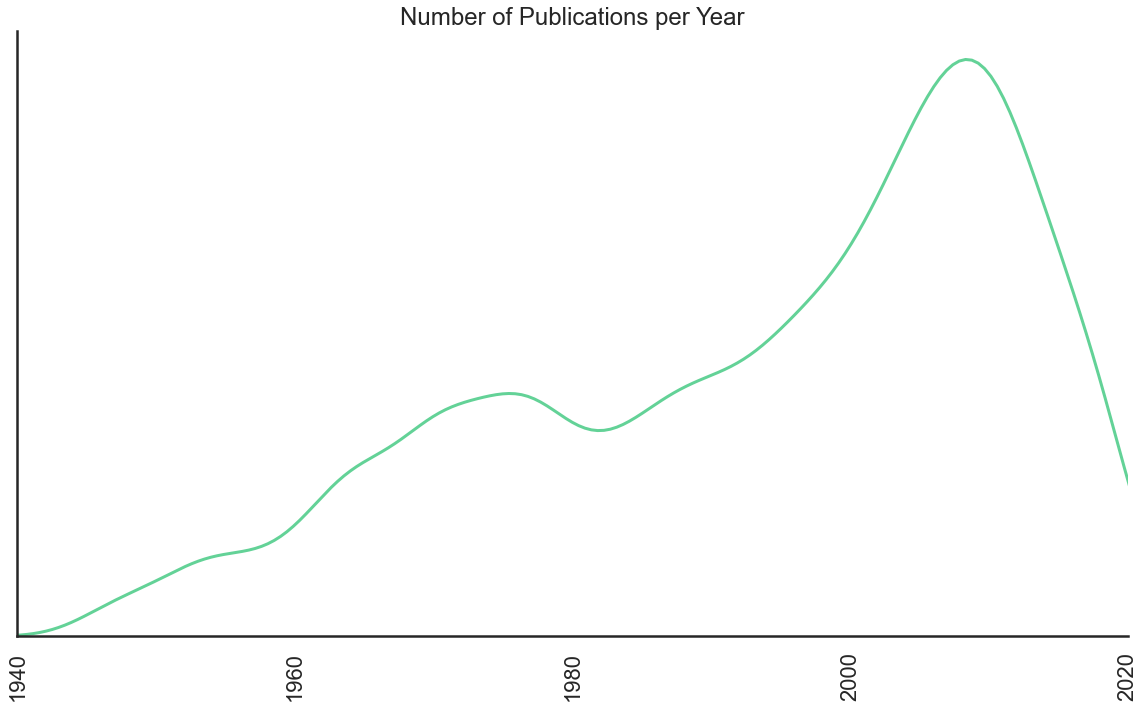

In [35]:
sns.set(context = 'poster', style = 'white')

x = df_clean['year'].sort_values(ascending = True)
xlabel = ''
ylabel = ''
yticks = ''
title = 'Number of Publications per Year'

plt.figure(figsize=(20,10))
ax = sns.displot(data = x, kind = 'kde', color = '#63d297', aspect = 1.75, height = 10)
ax.set_xticklabels(rotation=90)
ax.set(xlabel = xlabel, yticklabels = yticks, ylabel = ylabel, xlim = (1940, 2020), title = title)

plt.show()

# Data Inputing with Categorical Modeling

I want to recommend documents that are significant, and the best way to do so is by looking at their reference number.  However, a large number of documents in our dataframe have missing values as their reference numbers, so I want to fill them in as I do not want to disregard documents just because they aren't popular.  I will use NLP to read the terms and use a classification model to determine whether or not they can be considered significant enough for us to use.  In terms of metric, I will mainly care about the metric 'precision', due to the fact that as I want to ensure that the documents I acknowledge are truly significant.

First I separate our dataframe into two, with one dataframe containing rows with a reference number and the other wiithout.  This will conveniently become our Training and Testing datasets.

In [36]:
df_rf = df_clean[df_clean['reference_number'] > 0].reset_index(drop = True)
df_no_rf = df_clean[df_clean['reference_number'] == 0].reset_index(drop = True)

Next I turn our reference numbers into labels, by labeling any row with a reference number over a certain threshold as '1' for significant, and '0' otherwise.

In [120]:
'''
function for setting the target value; I will consider any document with a reference number 
over the threshold as being significant with the label '1', and anything else with a label '0'

input:
- int/float as the reference number

output:
- int of 0 or 1 as its label
'''
def relevant_labeling(rf):
    if rf > df_rf['reference_number'].describe()['25%']:
        return 1
    else:
        return 0
    
df_rf['relevant'] = df_rf['reference_number'].map(relevant_labeling)

For the MVP, I will only use the 'terms' as the input of our model; I set that as X while setting our target variable 'relevant' as y.

In [38]:
X = df_rf['terms']
y = df_rf['relevant']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

Then I use a count vectorizer to turn our rows of terms into rows of token counts.  This will be our input for our model.

In [39]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv = pd.DataFrame.sparse.from_spmatrix(X_train_cv)
X_train_cv.columns = sorted(cv.vocabulary_)

X_test_cv = cv.transform(X_test)
X_test_cv = pd.DataFrame.sparse.from_spmatrix(X_test_cv)
X_test_cv.columns = sorted(cv.vocabulary_)

I start with a basic Linear Regression model.

In [40]:
lr1 = LogisticRegression(max_iter=10000)
lr1.fit(X_train_cv, y_train)

y_pred1 = lr1.predict(X_test_cv)
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(recall_score(y_test, y_pred1))
print(f1_score(y_test, y_pred1))

0.7085889570552147
0.7680608365019012
0.8559322033898306
0.8096192384769539


Then using gridsearch, I attempt to hyperparameter tune linear regression to get a better version.

In [ ]:
param_grid = {
    'max_iter': [10000],
    'solver': ['liblinear', 'sag'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [10, 1.0, 0.1],
    'tol': [0.0001, 0.1, 1, 100]
}

gs1 = GridSearchCV(LogisticRegression(), param_grid)
gs1.fit(X_train_cv, y_train)

In [ ]:
gs1.best_estimator_

Will not show the results of the grid search in the report notebook, but the best estimator that is given is used below.

In [41]:
lr2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.1, verbose=0,
                   warm_start=False)

lr2.fit(X_train_cv, y_train)
y_pred2 = lr2.predict(X_test_cv)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))
print(f1_score(y_test, y_pred2))

0.6993865030674846
0.7395833333333334
0.902542372881356
0.8129770992366412


Recall and F1 score has gone up, but precision has gone down.  Since I only care about precision, I won't use this.

Next I will try it with a tfidf vectorizer instead of a count vectorizer.

In [44]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
X_train_tfidf.columns = sorted(cv.vocabulary_)

X_test_tfidf = tfidf.transform(X_test)
X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf)
X_test_tfidf.columns = sorted(tfidf.vocabulary_)

In [46]:
lr3 = LogisticRegression(max_iter=10000)
lr3.fit(X_train_tfidf, y_train)

y_pred3 = lr3.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(recall_score(y_test, y_pred3))
print(f1_score(y_test, y_pred3))

0.7300613496932515
0.7371794871794872
0.9745762711864406
0.8394160583941606


Precision has gone down again; thus I will stick with our first model.


# Content Based Recommender System with Cosine Similarities

With our chosen model, I will then go through the dataframe of rows without reference numbers and give them a label of whether or not they can be considered significant enough to be recommended.

In [47]:
X_no_rf = cv.transform(df_no_rf['terms'])
y_pred_rf = lr1.predict(X_no_rf)
df_no_rf['relevant'] = y_pred_rf

I can then combine both the dataframe with reference numbers and the dataframe without reference numbers into one, final dataframe.  After that, I can quickly sort out the non-relevant documents too by filtering out the rows with a label of '0'.

In [48]:
df_final = pd.concat([df_rf, df_no_rf])
df_final = df_final[df_final['relevant'] == 1]

Next I sorted the rows by reference number and found the most significant one based on which row had the highest amount.  I then set that as the best document and then will proceed to base my future recommendations on it.

In [49]:
df_final = df_final.sort_values(by = ['reference_number'], ascending = False).reset_index(drop = True)
best = df_final.iloc[0]

In [50]:
best

title               Allergic Rhinitis and its Impact on Asthma (AR...
authors             bousquet_j khaltaev_n cruz_aa denburg_j fokken...
journal                                                       allergy
abstract                                                             
reference_number                                                 2241
location                                                      denmark
language                                                          eng
year                                                             2008
terms               adolescent asthma epidemiology etiology therap...
relevant                                                            1
Name: 0, dtype: object

I use count vectorizer yet again on the terms, and then perform cosine similarity on it to find the rows that are the most similar to my best document.

In [51]:
cv = CountVectorizer()
X_cv = cv.fit_transform(df_final['terms'])
X_cv = pd.DataFrame.sparse.from_spmatrix(X_cv)
X_cv.columns = sorted(cv.vocabulary_)
X_cv = X_cv.to_numpy()

In [52]:
numerators = np.array([X_cv[0].dot(i) for i in X_cv[1:]])
denominators = np.array([np.sqrt(sum(X_cv[0]**2)) *\
                         np.sqrt(sum(i**2)) for i in X_cv[1:]])

results_cv = numerators / denominators

A higher cosine similarity means that the document is more similar, so I will take the rows with the top 4 cosine similarity value.

In [53]:
ind = np.argpartition(results_cv, -4)[-4:]
print('Top 4 Cosine Similarity Scores')
print(results_cv[ind])
print('\nIndex of the Documents:')
print(ind)


Top 4 Cosine Similarity Scores
[0.79203    0.79314397 0.83827364 0.79850937]

Index of the Documents:
[ 9625  5816   166 10295]


The following is some code to help visualize our findings.

In [55]:
ti = df_final.iloc[ind]['title'].reset_index(drop = True)
au = df_final.iloc[ind]['authors'].reset_index(drop = True)
jor = df_final.iloc[ind]['journal'].reset_index(drop = True)
loc = df_final.iloc[ind]['location'].reset_index(drop = True)
lan = df_final.iloc[ind]['language'].reset_index(drop = True)
yr = df_final.iloc[ind]['year'].reset_index(drop = True)

In [56]:
print('\nBest Article:\n')
print("Title: " + best['title'])
print("Author(s): " + best['authors'])
print("Journal: " + best['journal'])
print("Location: " + best['location'])
print("Language: " + best['language'])
print("Year: " + str(best['year']))

print('\n\n4 Further Recommended:\n')

for x in range(0,4):
    print("Title: " + ti[x])
    print("Author(s): " + au[x])
    print("Journal: " + jor[x])
    print("Location: " + loc[x])
    print("Language: " + lan[x])
    print("Year: " + str(yr[x]))
    print("\n")


Best Article:

Title: Allergic Rhinitis and its Impact on Asthma (ARIA) 2008 update (in collaboration with the World Health Organization, GA(2)LEN and AllerGen).
Author(s): bousquet_j khaltaev_n cruz_aa denburg_j fokkens_wj togias_a zuberbier_t baenacagnani_ce canonica_gw van_weel_c agache_i aitkhaled_n bachert_c blaiss_ms bonini_s boulet_lp bousquet_pj camargos_p carlsen_kh chen_y custovic_a dahl_r demoly_p douagui_h durham_sr van_wijk_rg kalayci_o kaliner_ma kim_yy kowalski_ml kuna_p le_lt lemiere_c li_j lockey_rf mavalemanuel_s meltzer_eo mohammad_y mullol_j naclerio_r "ohehir_re"_ohta_k ouedraogo_s palkonen_s papadopoulos_n passalacqua_g pawankar_r popov_ta rabe_kf rosadopinto_j scadding_gk simons_fe toskala_e valovirta_e van_cauwenberge_p wang_dy wickman_m yawn_bp yorgancioglu_a yusuf_om zar_h annesimaesano_i bateman_ed ben_kheder_a boakye_da bouchard_j burney_p busse_ww chanyeung_m chavannes_nh chuchalin_a dolen_wk emuzyte_r grouse_l humbert_m jackson_c johnston_sl keith_pk kemp

# Explanatory Data Analysis

Explanatory data analysis is analysis and visualizing the results.

CHANGE LATER => As this wasn't required for the MVP, this will be considered stretch goals and polish; for now I just have a sunburst plot that showcases the journals that published the recommended articles above, as well as the top 5 authors that work for them based on number of publications.

In [74]:
one = [best['journal'].replace('_', ' ').title(), [x[0].replace('_', ' ').title() for x in column_counter(df_final[df_final['journal'] == best['journal']], 'authors' ).most_common(5)]]
two = [jor[0].replace('_', ' ').title(), [x[0].replace('_', ' ').title() for x in column_counter(df_final[df_final['journal'] == jor[0]], 'authors' ).most_common(5)]]
three = [jor[1].replace('_', ' ').title(), [x[0].replace('_', ' ').title() for x in column_counter(df_final[df_final['journal'] == jor[1]], 'authors' ).most_common(5)]]
four = [jor[2].replace('_', ' ').title(), [x[0].replace('_', ' ').title() for x in column_counter(df_final[df_final['journal'] == jor[2]], 'authors' ).most_common(5)]]
five = [jor[3].replace('_', ' ').title(), [x[0].replace('_', ' ').title() for x in column_counter(df_final[df_final['journal'] == jor[3]], 'authors' ).most_common(5)]]

In [113]:
data = dict(
    character=[one[0], two[0], three[0], four[0], five[0]] + one[1] + two[1] + three[1] + four[1] + five[1],
    parent=['', '', '', '', ''] + ([one[0]] * 5) + ([two[0]] * 5) + ([three[0]] * 5) + ([four[0]] * 5) + ([five[0]] * 5))

fig =px.sunburst(
    data,
    names='character',
    parents='parent',
)
fig.update_layout(
    margin = dict(t=40, l=40, r=40, b=40)
)
fig.show()